In [1]:
%load_ext autoreload
%autoreload 2

# import imp
# import utils
# imp.reload(utils)
# import utils

# Settings, Directory Specs, and Imports

In [2]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_random_state
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection._split import _RepeatedSplits
from collections import defaultdict
from collections import Counter
import sys
sys.path.insert(1, '../src')
from utils import *




matplotlib.rcParams.update({'font.size': 22})

# Defining X and y

In [3]:
Xy = pd.read_csv(dir_read + 'Xy_2020_06_15_1449.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
groups = Xy['uniquepid'].astype('category').cat.codes # each uniquepid is now a unique number
X = X.drop(columns='uniquepid', axis=1) # remove uniquepid as a feature because it's a group

vars_categ = ['gender_Female', 'ethnicity_African American', 'ethnicity_Asian', 'ethnicity_Caucasian', \
             'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',\
             'thrombolytics', 'aids', 'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', \
             'immunosuppression', 'cirrhosis', 'activetx', 'ima', 'midur',
             'oobventday1', 'oobintubday1', 'diabetes']
vars_cont = ['age', 'admissionweight', 'admissionheight', 'bmi', \
             'verbal', 'motor', 'eyes', 'visitnumber', 'heartrate']
print('There are ' + str(len(vars_categ)) + ' categorical features')
print('There are ' + str(len(vars_cont)) + ' continuous features')
X = pd.concat([X[vars_cont], X[vars_categ]], axis=1)
X.head()

There are 21 categorical features
There are 9 continuous features


,age,admissionweight,admissionheight,bmi,verbal,motor,eyes,visitnumber,heartrate,gender_Female,...,metastaticcancer,leukemia,immunosuppression,cirrhosis,activetx,ima,midur,oobventday1,oobintubday1,diabetes
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141168,70,84.3,152.4,36.295906,5,6,4,1,125.052830,1,...,0,0,0,0,1,0,0,0,0,0
141194,68,73.9,180.3,22.732803,4,6,3,1,86.860627,0,...,0,0,0,0,0,0,0,0,0,1
141197,71,102.1,162.6,38.617545,5,6,4,1,97.307692,0,...,0,0,0,0,0,0,0,0,0,0
141203,77,70.2,160.0,27.421875,1,3,1,1,91.543554,1,...,0,0,0,0,1,0,0,1,0,1
141208,25,95.3,172.7,31.952749,5,6,3,1,77.817460,1,...,0,0,0,0,0,0,0,0,0,0


## Split into X_trainval, y_trainval, X_test, y_test using StratifiedGroupKFold()

In [4]:
# Split into 80/20 train&val/test using StratifiedGroupKFold(). Since 
cv = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=1)
trainval_idx, test_idx = next(cv.split(X, y, groups))
X_trainval = X.iloc[trainval_idx]
y_trainval = y.iloc[trainval_idx]
X_test = X.iloc[test_idx]
y_test = y.iloc[test_idx]

In [5]:
X_trainval.shape

(117006, 30)

In [6]:
X_test.shape

(29253, 30)

# Logistic Regression

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# For logistic regression, scale the data
scaler = MinMaxScaler()
X_trainval_sc = np.concatenate([scaler.fit_transform(X_trainval[vars_cont]), \
                             X_trainval[vars_categ].to_numpy()], axis=1)
X_test_sc = np.concatenate([scaler.fit_transform(X_test[vars_cont]), \
                             X_test[vars_categ].to_numpy()], axis=1)

# Create base classifier
clf = LogisticRegression(class_weight='balanced')

# StratifiedGroupKFold takes a long time, so for tuning hyperparameters, just use StratifiedKFold    
skf = StratifiedKFold(n_splits=10) 
    
# Create grid of hyperparameters
hyperparam_grid = {'penalty': ['l1', 'l2'], \
                   'C': np.logspace(-6, 3, 10), \
                   #'C': [0.001, 0.01], \
                   'fit_intercept': [True, False]}

# Perform grid search
grid_search = GridSearchCV(clf, scoring='roc_auc', param_grid=hyperparam_grid, refit=True,
                       cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_trainval_sc, y_trainval)

print(grid_search.best_params_)

#grid_search_clf_rocauc = grid_search_wrapper(clf, X_train_sc, y_train, 'roc_auc')

{'C': 0.01, 'fit_intercept': True, 'penalty': 'l2'}


In [8]:
#C=0.01, fit_intercept=True, penalty='l2'
#C=0.0001, fit_intercept=False, penalty='l2'
clf_w_best_params = LogisticRegression(class_weight = 'balanced', C=0.01, fit_intercept=True, penalty='l2')
clf_w_best_params.fit(X_trainval_sc, y_trainval)

model_and_scaler = {'model': clf_w_best_params, 'scaler': scaler}
pickle.dump(model_and_scaler, open('../models/model_scaler_logRegr_' + now_to_str() + '.pickle', 'wb'))

y_pred = clf_w_best_params.predict(X_test_sc)
y_probs = clf_w_best_params.predict_proba(X_test_sc)[:,1]

print('AUC is ' + str(roc_auc_score(y_test,y_probs)))
print('Min. probability is {:.4f}'.format(y_probs.min()))
print('Max. probability is {:.4f}'.format(y_probs.max()))

AUC is 0.7231709035769114
Min. probability is 0.0348
Max. probability is 0.9472


(array([  61.,  579., 1841., 3041., 3531., 3235., 2640., 2208., 2002.,
        1651., 1501., 1432., 1325., 1254., 1119.,  836.,  594.,  285.,
          96.,   22.]),
 array([0.03477997, 0.08040297, 0.12602597, 0.17164897, 0.21727197,
        0.26289497, 0.30851797, 0.35414096, 0.39976396, 0.44538696,
        0.49100996, 0.53663296, 0.58225596, 0.62787896, 0.67350195,
        0.71912495, 0.76474795, 0.81037095, 0.85599395, 0.90161695,
        0.94723995]),
 <a list of 20 Patch objects>)

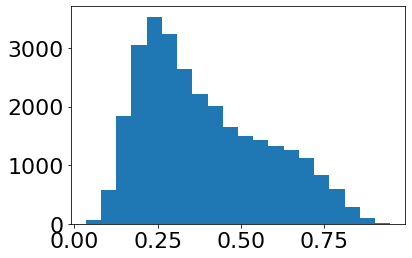

In [9]:
plt.hist(y_probs, bins=20)

Logistic: ROC AUC=0.723


<IPython.core.display.Javascript object>


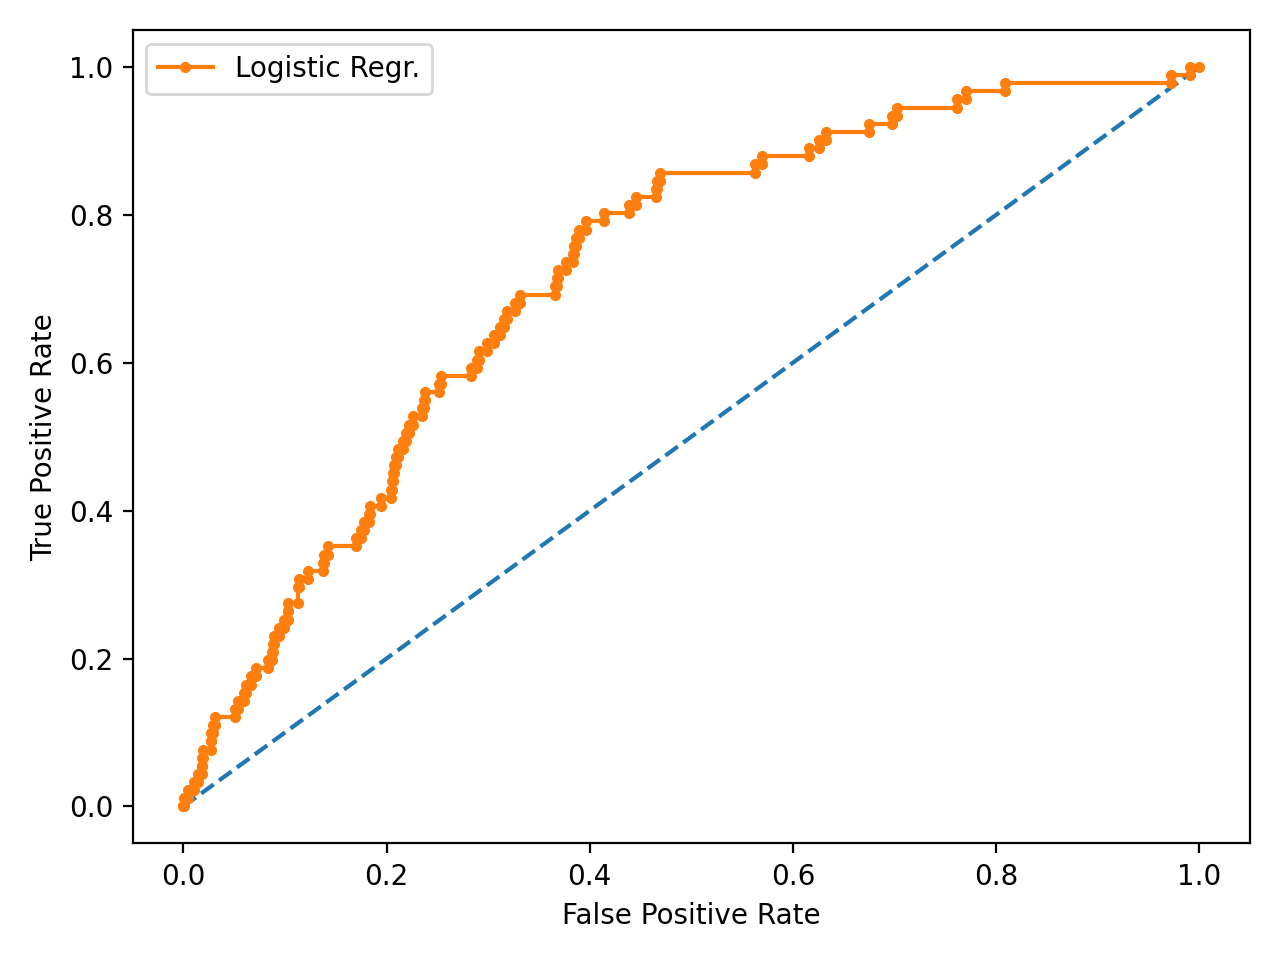

In [15]:
%matplotlib notebook


noskill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, threshold_array = roc_curve(y_test, clf_w_best_params.predict_proba(X_test_sc)[:,1])

y_pred_new = lr_tpr>0

logisticRegr_auc = roc_auc_score(y_test, y_probs)
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# # show the legend
plt.legend()
plt.tight_layout()
# # show the plot
plt.show()

In [11]:
# # Looking at ROC curve, a TPR of 0.88 and FPR of 0.48 seems reasonable because the prophylaxis may
# # cause bleeding, but VTE is deadly, too. Get the threshold at this level
# fpr_tpr_thresh = pd.DataFrame({'fpr': lr_fpr, 'tpr': lr_tpr, 'thresh': threshold_array})
# fpr_tpr_thresh = fpr_tpr_thresh[(fpr_tpr_thresh['tpr'] < 0.92) & (fpr_tpr_thresh['tpr'] > 0.80)]
# fpr_tpr_thresh

# Xt = X_test_sc
# yt = y_test

# THRESHOLD = [0.0017, 0.0018, 0.0019, 0.0020, 0.0021, 0.0022, 0.0023, 0.0024, 0.0025, 0.0026, 0.0027]
# for thresh in THRESHOLD:
#     print('-----------------')
#     print('THRESHOLD =  ' + str(thresh))
#     y_pred_thresh = np.where(clf_w_best_params.predict_proba(Xt)[:,1] > thresh, 1, 0)
#     print('F1: ' + str(f1_score(yt, y_pred_thresh)))
#     print('Precision: ' + str(precision_score(yt, y_pred_thresh)))
#     print('Recall: ' + str(recall_score(yt, y_pred_thresh)))
#     print(confusion_matrix(yt, y_pred_thresh, normalize='true'))

# Feature Weights

In [16]:
# Get feature weights and put into dataframe
mydict = {'feature': X_trainval.columns, 'coef': list(clf_w_best_params.coef_.reshape(-1,1).flatten())}
features_weights = pd.DataFrame(mydict)
features_weights = features_weights.assign(abs_weight=np.abs(features_weights['coef']))
features_weights.head()

,feature,coef,abs_weight
0,age,0.590638,0.590638
1,admissionweight,1.263164,1.263164
2,admissionheight,-0.178252,0.178252
3,bmi,0.825222,0.825222
4,verbal,-0.276033,0.276033


In [13]:
fw = features_weights.sort_values(by='abs_weight', ascending=False)

In [17]:
fw5 = fw.iloc[0:5]
fw5

,feature,coef,abs_weight
8,heartrate,2.996043,2.996043
25,ima,-1.568767,1.568767
1,admissionweight,1.263164,1.263164
7,visitnumber,0.953552,0.953552
3,bmi,0.825222,0.825222
